# Are abstractions used?

In [1]:
import sys

sys.path.append("../")

%load_ext autoreload
%autoreload 2

import os
import json
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# import data.drawings.make_tasks as drawing_tasks
from src.analysis_utilities import SynthesisExperimentAnalyzer
from src.config_builder import ExperimentType


/opt/conda/envs/lilo/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

DOMAIN = "clevr"
COMPUTE_LIKELIHOODS = True
EXPERIMENT_TYPE = ["gpt_solver_learner_2_gpt4"]
iteration = "9"
result_filepath = "gpt_library_abstraction_results.json"

def load_gpt_data(seed,iteration,experiment_name,domain):
    path = os.path.join(
        "..",
        "experiments_iterative",
        "outputs",
        experiment_name,
        "domains",
        domain,
        EXPERIMENT_TYPE[0],
        f"seed_{seed}",
        f"{EXPERIMENT_TYPE[0]}_96",
        iteration,
        "train",
        result_filepath
    )

    try:
        # Try to open the file and load the JSON data
        with open(path, 'r') as file:
            data = json.load(file)

        # If the data is loaded successfully, process it to create a dataframe
        df_data = [{'function_expression': v['function_expression'], 'compression_ratio': v['compression_ratio']} for k, v in data['abstractions'].items()]
        df = pd.DataFrame(df_data)
        df["cumulative_compression_ratio"] = (df["compression_ratio"] - 1).cumsum() + 1

    except FileNotFoundError:
        # If the file is not found, create an empty dataframe
        df = pd.DataFrame(columns=['function_expression', 'compression_ratio','cumulative_compression_ratio'])
    
    
    return df

In [3]:
def load_stitch_data(seed,domain,iteration):
    path = os.path.join(
        "..",
        "experiments_iterative",
        "outputs",
        "runs_multi",
        "domains",
        domain,
        "baseline_dreamcoder",
        f"seed_{seed}",
        "baseline_dreamcoder_96",
        iteration,
        "train",
        "stitch_compress_output.json"
    )

    with open(path, 'r') as file:
        data = json.load(file)

    # Extract cumulative compression ratio
    abstractions = [entry['dreamcoder'] for entry in data['abstractions']]
    cumulative_ratios = [entry['cumulative_compression_ratio'] for entry in data['abstractions']]
    return pd.DataFrame({"function_expression":abstractions, "cumulative_compression_ratio": cumulative_ratios})

In [ ]:
# plot cumulative compression ratio over abstraction in final iteration
# should be 3 subplots for each domain, each with 3 lines 
data_list = []
domains = ["re2","clevr","logo"]
for domain in domains:
    if domain == "re2":
        last_iteration = 15
    else:
        last_iteration = 10
    for seed in [111,222,333]:
        for experiment_name in ["random","cluster"]:
            gpt_data = load_gpt_data(seed, str(last_iteration),experiment_name,domain)
            for index, row in gpt_data.iterrows():
            cumulative_compression_ratio = row["cumulative_compression_ratio"]
            data_list.append([domain, seed, index, cumulative_compression_ratio, experiment_name])
        stitch_data = load_gpt_data(seed ,domain, str(last_iteration))
        for index, row in stitch_data.iterrows():
            cumulative_compression_ratio = row["cumulative_compression_ratio"]
            data_list.append([domain, seed, index, cumulative_compression_ratio, experiment_name])
dataframe = pd.DataFrame(data_list, columns=['Domain', 'Seed', 'Num_abstraction', 'Compression_ratio','Method'])

SyntaxError: invalid syntax (2108238935.py, line 10)

In [ ]:
# Group by 'Domain', 'Method', and 'Iteration' and calculate the mean, max, and min
grouped = dataframe.groupby(['Domain', 'Method', 'Num_abstraction'])
stats = grouped['Compression_ratio'].agg(['mean', 'max', 'min'])
# Unique domain values and methods
domains = dataframe['Domain'].unique()
methods = dataframe['Method'].unique()

# Creating a figure with subplots (3 subplots for 3 domains in this case)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))  # 3 subplots in a row

# Adjust the space between the plots and set a common label
fig.subplots_adjust(bottom=0.15, wspace=0.3)  # Adjust spacing as needed
fig.text(0.5, 0.04, 'Domain', ha='center', va='center')

for i, domain in enumerate(domains):
    ax = axes[i]  # Current axes instance

    for method in methods:
        # Filter the statistics for the current domain and method
        data = stats.xs((domain, method), level=('Domain', 'Method'))

        # Plotting the mean with a line
        data['mean'].plot(ax=ax, label=f'{method}', linestyle='-', marker='')

        # Plotting the range between max and min with a fill
        ax.fill_between(data.index, data['min'], data['max'], alpha=0.2)

    # Set the title and labels
    ax.set_title(domain)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Compression Ratio')
    ax.legend()
    ax.set_ylim(0.5,4)

plt.show()


In [10]:
#plot cumulative compression ratio over iterations

data_list = []
domains = ["re2","clevr","logo"]
for domain in domains:
    if domain == "re2":
        n_iteration = 15
    else:
        n_iteration = 10
    for i in range(n_iteration):
        for seed in [111,222,333]:
            for experiment_name in ["random","cluster"]:
                gpt_data = load_gpt_data(seed,str(i),experiment_name,domain)
                if not gpt_data.empty:
                    cumulative_compression_ratio = gpt_data.iloc[-1]["cumulative_compression_ratio"]
                    data_list.append([domain,seed,i,cumulative_compression_ratio,experiment_name])
                else:
                    data_list.append([domain,seed,i,1,experiment_name])
            stitch_data = load_stitch_data(seed,domain,str(i))
            cumulative_compression_ratio = stitch_data.iloc[-1]["cumulative_compression_ratio"]
            data_list.append([domain,seed,i,cumulative_compression_ratio,"stitch"])
dataframe = pd.DataFrame(data_list, columns=['Domain', 'Seed', 'Iteration', 'Compression_ratio','Method'])
pd.set_option('display.max_rows', None)
print(dataframe)



    Domain  Seed  Iteration  Compression_ratio   Method
0      re2   111          0           1.071327   random
1      re2   111          0           1.057861  cluster
2      re2   111          0           1.862915   stitch
3      re2   222          0           1.000000   random
4      re2   222          0           1.025793  cluster
5      re2   222          0           2.124580   stitch
6      re2   333          0           1.058369   random
7      re2   333          0           1.002798  cluster
8      re2   333          0           2.108672   stitch
9      re2   111          1           1.057290   random
10     re2   111          1           1.072218  cluster
11     re2   111          1           2.070142   stitch
12     re2   222          1           1.197948   random
13     re2   222          1           1.074155  cluster
14     re2   222          1           2.240381   stitch
15     re2   333          1           1.040553   random
16     re2   333          1           1.040553  

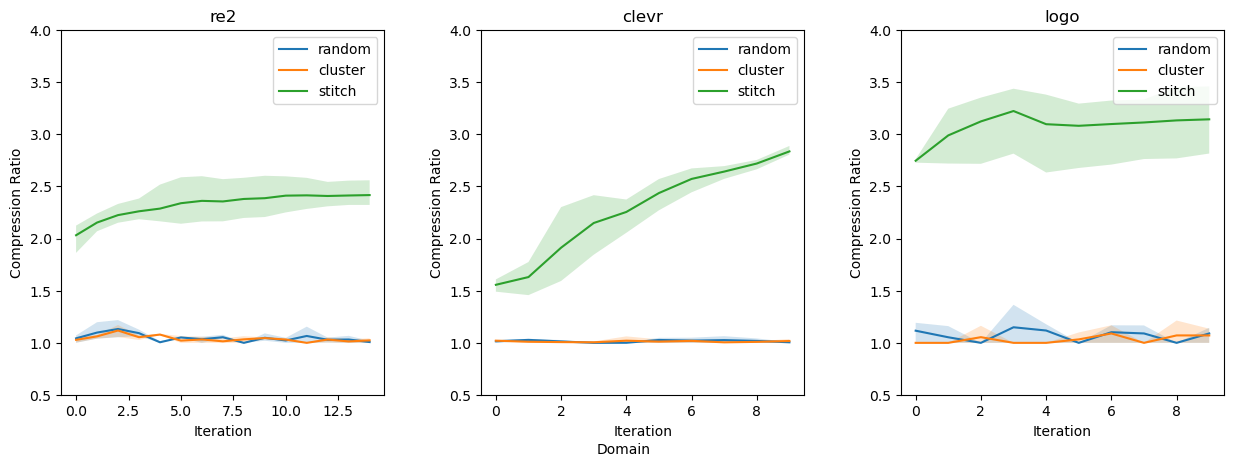

In [20]:
# Group by 'Domain', 'Method', and 'Iteration' and calculate the mean, max, and min
grouped = dataframe.groupby(['Domain', 'Method', 'Iteration'])
stats = grouped['Compression_ratio'].agg(['mean', 'max', 'min'])
# Unique domain values and methods
domains = dataframe['Domain'].unique()
methods = dataframe['Method'].unique()

# Creating a figure with subplots (3 subplots for 3 domains in this case)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))  # 3 subplots in a row

# Adjust the space between the plots and set a common label
fig.subplots_adjust(bottom=0.15, wspace=0.3)  # Adjust spacing as needed
fig.text(0.5, 0.04, 'Domain', ha='center', va='center')

for i, domain in enumerate(domains):
    ax = axes[i]  # Current axes instance

    for method in methods:
        # Filter the statistics for the current domain and method
        data = stats.xs((domain, method), level=('Domain', 'Method'))

        # Plotting the mean with a line
        data['mean'].plot(ax=ax, label=f'{method}', linestyle='-', marker='')

        # Plotting the range between max and min with a fill
        ax.fill_between(data.index, data['min'], data['max'], alpha=0.2)

    # Set the title and labels
    ax.set_title(domain)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Compression Ratio')
    ax.legend()
    ax.set_ylim(0.5,4)

plt.show()


In [ ]:
# analysis of length, arity, yield


In [41]:
analyzer = SynthesisExperimentAnalyzer(
    experiment_name=EXPERIMENT_NAME,
    experiment_types = EXPERIMENT_TYPE,
    allow_incomplete_results=True,
    compute_likelihoods=COMPUTE_LIKELIHOODS,
    batch_size = 96,
    domains = [DOMAIN],
    seeds = [111, 222, 333],
    
)

Experiment directory: ../experiments_iterative/outputs/runs_gpt_learner
Available domains: ['re2']


In [42]:
df_results = analyzer.get_synthesis_results()
mask = df_results["programs"].apply(lambda x: x != [])
df_results = df_results[mask]
df_results

,request,task,programs,best_search_time,split,solved,seed,iteration,experiment_type,domain
13,"{'constructor': '->', 'arguments': [{'construc...",re2_train_14_if_there_is_t_replace_that_with_a_x,[{'program': '(lambda (_rflatten (map (lambda ...,NaN,train,True,111,0,gpt_solver_learner_gpt4,re2
20,"{'constructor': '->', 'arguments': [{'construc...",re2_train_21_if_the_word_starts_with_any_lette...,[{'program': '(lambda (_rflatten (cons _n (con...,1.451924,train,True,111,0,gpt_solver_learner_gpt4,re2
31,"{'constructor': '->', 'arguments': [{'construc...",re2_train_32_if_there_is_p_replace_that_with_f_w,[{'program': '(lambda (_rflatten (map (lambda ...,NaN,train,True,111,0,gpt_solver_learner_gpt4,re2
33,"{'constructor': '->', 'arguments': [{'construc...",re2_train_34_if_the_word_ends_with_any_letter_...,[{'program': '(lambda (_rflatten (_rappend _d ...,0.000519,train,True,111,0,gpt_solver_learner_gpt4,re2
40,"{'constructor': '->', 'arguments': [{'construc...",re2_train_41_if_there_is_any_letter_add_v_afte...,[{'program': '(lambda (_rflatten (map (lambda ...,0.000772,train,True,111,0,gpt_solver_learner_gpt4,re2
...,...,...,...,...,...,...,...,...,...,...
1947,"{'constructor': '->', 'arguments': [{'construc...",re2_train_474_if_there_is_t_replace_that_with_o,[{'program': '(lambda (_rflatten (map (lambda ...,NaN,train,True,111,2,gpt_solver_learner_gpt4,re2
1950,"{'constructor': '->', 'arguments': [{'construc...",re2_train_477_if_there_is_s_replace_that_with_i_r,[{'program': '(lambda (_rflatten (map (lambda ...,NaN,train,True,111,2,gpt_solver_learner_gpt4,re2
1957,"{'constructor': '->', 'arguments': [{'construc...",re2_train_484_if_the_word_ends_with_consonant_...,[{'program': '(lambda (if (_rmatch _e (_rtail ...,NaN,train,True,111,2,gpt_solver_learner_gpt4,re2
1959,"{'constructor': '->', 'arguments': [{'construc...",re2_train_486_if_the_word_starts_with_any_lett...,[{'program': '(lambda (_rflatten (cons _b (_rs...,NaN,train,True,111,2,gpt_solver_learner_gpt4,re2


In [43]:
programs = df_results['programs'].tolist()
programs_list = []
for task in programs:
    for program in task:
        programs_list.append(program["program"])

In [44]:
abstraction = analyzer.get_gpt_abstractions_for_domain(domain = DOMAIN, experiment_types = EXPERIMENT_TYPE)
for program in programs_list:
    for name in abstraction['function_name']:
        if name in program:   
            print('🍊')

In [59]:
import json
path = "/home/ubuntu/lilo/experiments_iterative/outputs/runs_gpt_learner/domains/re2/gpt_solver_learner_gpt4/seed_111/gpt_solver_learner_gpt4_96/1/train/gpt_solver_results.json"
with open(path, 'r') as f:
    data = json.load(f)

In [52]:
programs = []
for x in data["results_by_query"]:
    answer = x["completion"]["choices"]
    for y in answer:
        program = y["text"]
        programs.append(program)
        for name in abstraction['function_name']:
            if name in program:
                print('🍊')
print(len(programs))



1148


In [62]:
for x in data["results_by_query"]:
    answer = x["parse_results"]
    for y in answer:
        program = y["text"]
        programs.append(program)
        for name in abstraction['function_name']:
            if name in program:
                print(program)
                print (y["valid"])
                if not y["valid"]:
                    print (y["error"])
                print ("---")

(lambda (regex_replace_any_letter $0 (regex_match 'e' $2) (regex_match 'i' $1)))
False
infer
---
(lambda (modify_word $0 '.' 'h' 'p'))
False
infer
---
(lambda (modify_word_based_on_consonant $0 (regex_flatten (regex_map (lambda (regex_if (regex_match 't' $0) 'l' $0)) (regex_split '.' $0))) (regex_flatten (regex_map (lambda (regex_if (regex_match 'e' $0) 'j' $0)) (regex_split '.' $0))))))
False
parse
---
(lambda (modify_word_based_on_consonant $0 (regex_flatten (regex_map (lambda (regex_if (regex_match 't' $0) 'l' $0)) (regex_split '.' $0))) (regex_flatten (regex_map (lambda (regex_if (regex_match 'e' $0) 'j' $0)) (regex_split '.' $0))))))
False
parse
---
(lambda (regex_if (regex_match '.' (regex_tail (regex_split empty_string $0))) (regex_flatten (regex_replace_any_letter (regex_flatten (regex_map (lambda (regex_if (regex_match 'm' $0) 'j' $0)) (regex_split empty_string $0))))) (regex_flatten (regex_map (lambda (regex_if (regex_match 'm' $0) 'j' $0)) (regex_split empty_string $0)))))
F